In [58]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import learning_curve, ShuffleSplit, cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

from mne import Epochs, pick_types, events_from_annotations, EpochsArray, create_info
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import psd_array_welch, psd_array_multitaper, stft
import seaborn as sns
from tqdm import tqdm

In [140]:
# load batch_stft.npy and train_idx.npy
reconstructed_stft = np.load('preprocessed_data/reconstructed_stft.npy')
source_stft = np.load('preprocessed_data/source_stft.npy')
train_idx = np.load('preprocessed_data/train_idx.npy')
val_idx = np.load('preprocessed_data/val_idx.npy')
test_idx = np.load('preprocessed_data/test_idx.npy')
labels = np.load('preprocessed_data/labels.npy')

train_stft = source_stft[train_idx]
y_train = labels[train_idx]
welch_train = np.mean(train_stft, axis=3)


In [141]:
print(welch_train.shape)
print(y_train.shape)

(3725, 4, 81)
(3725,)


In [ ]:
# numerical integration over PSD as a means of dim reduction



In [133]:
# partion train, test, val
scaler = StandardScaler()

X_train = welch_train.reshape(welch_train.shape[0], -1)
print(X_train.shape)
X_train = scaler.fit_transform(X_train)

# # shuffle split the remaining data between test and validation
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
# test_idx, val_idx = next(sss.split(source_stft[~train_idx], labels[~train_idx]))

X_val = np.mean(source_stft[val_idx], axis=3)
X_val = scaler.transform(X_val.reshape(X_val.shape[0], -1))
y_val = labels[val_idx]


(3725, 324)


In [96]:
# export test idx
np.save('preprocessed_data/test_idx.npy', test_idx)

# Logistic Regression Prelim Tests

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       237
           1       0.69      0.71      0.70       229

    accuracy                           0.70       466
   macro avg       0.70      0.70      0.70       466
weighted avg       0.70      0.70      0.70       466

ROC AUC: 0.6997770530466346


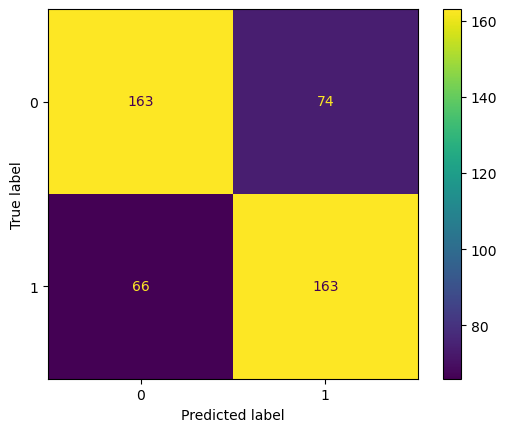

In [146]:
# train logistic regression model

# Fit a logistic regression model
clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_val)

# Compute accuracy score
# accuracy = accuracy_score(y_val, y_pred)
confusion = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)
roc = roc_auc_score(y_val, y_pred)

# print('Accuracy:', accuracy)
print(class_report)
print('ROC AUC:', roc)
ConfusionMatrixDisplay(confusion).plot();




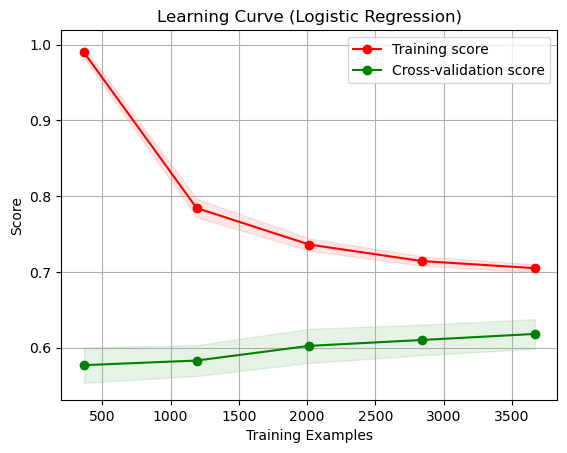

In [143]:
# create a logistic regression classifier
# clf = LogisticRegression(solver='lbfgs', max_iter=1000)

# merge train and val 
X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

# set the common parameters for learning curve
common_params = {
    "estimator": clf,
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.125, random_state=0), # 10% of overall data used for validation
    "n_jobs": -1,
    "shuffle": True,
}

# calculate the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(**common_params)

# plot the learning curve
plt.figure()
plt.title("Learning Curve (Logistic Regression)")
plt.xlabel("Training Examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()


In [144]:
print(np.mean(test_scores))

0.5979847328244275


(7476, 324)
(89, 84)


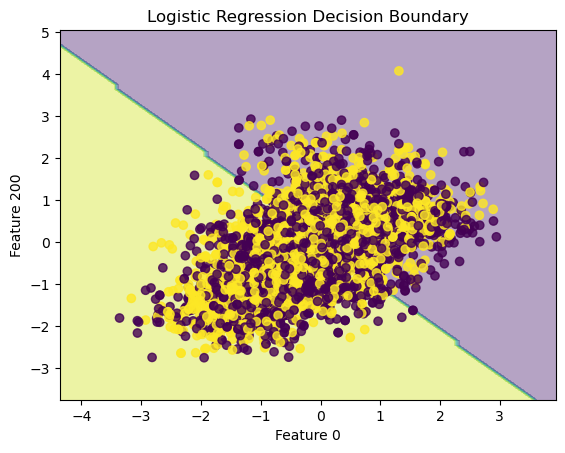

In [147]:
# Extract the coefficients and intercept of the logistic regression model
coef = clf.coef_.ravel()
intercept = clf.intercept_ 

# Select two features to plot the decision boundary
i = 0
j = 200

# Create a grid of points to evaluate the decision boundary
xmin, xmax = X[:, i].min() - 1, X[:, i].max() + 1
ymin, ymax = X[:, j].min() - 1, X[:, j].max() + 1
xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.1), np.arange(ymin, ymax, 0.1))

# Create input vector for model
# Fill with zeros for features that are not i or j
X_pred = np.zeros((len(xx.ravel()), X_train.shape[1]))
X_pred[:, i] = xx.ravel()
X_pred[:, j] = yy.ravel()
print(X_pred.shape)

Z = clf.predict(X_pred)
# Reshape the predictions to match the shape of the meshgrid
Z = Z.reshape(xx.shape)
print(Z.shape)

# Plot the decision boundary and the training data
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, i], X[:, j], c=y, alpha=0.8)
plt.xlabel('Feature {}'.format(i))
plt.ylabel('Feature {}'.format(j))
plt.title('Logistic Regression Decision Boundary')
plt.show()



(4191, 2)


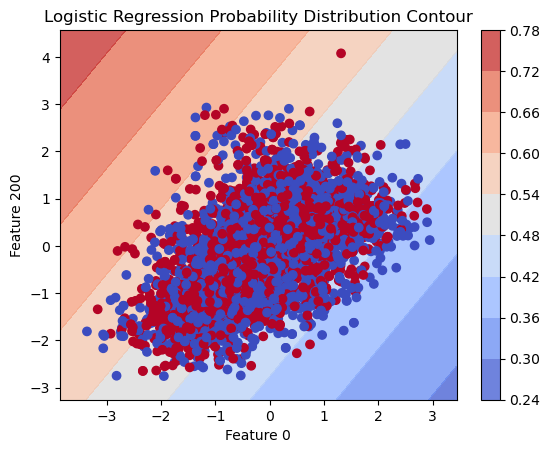

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# build data from 2 features
i = 0
j = 200
X_ij = X[:, [i, j]]
print(X_ij.shape)

# Fit the logistic regression model to the training set
clf = LogisticRegression().fit(X_ij, y)

# Create a meshgrid of feature values
h = 0.02  # step size in the mesh
x_min, x_max = X_ij[:, 0].min() - 0.5, X_ij[:, 0].max() + 0.5
y_min, y_max = X_ij[:, 1].min() - 0.5, X_ij[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Calculate predicted probabilities for each point in the meshgrid
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Plot the probability distribution contour
plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.colorbar()

# Plot the training set points
plt.scatter(X_ij[:, 0], X_ij[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Feature {}'.format(i))
plt.ylabel('Feature {}'.format(j))
plt.title('Logistic Regression Probability Distribution Contour')
plt.show()


Verdict: Log reg alone sucks as expected, pretty much dummy classifier level.

# FastAI Test

# Single Linear Layer NN Test
Basic linear layer followed by a sigmoid 

# CNN Sensor Fusion
Compressing 4xn sensor data into a single 1xn vector. 

# Single RNN Layer Test
Instead of using welch, pass in individual STFT time frames to a single RNN layer.

# Legendre Memory Unit